In [1]:
import get_rxnpair_info_copy
import zipfile
import pickle as pkl
from custom_chem import Atom, Bond, Molecule, Reaction
import json
from tqdm import tqdm
from rdkit import Chem


In [2]:
# old = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed.zip"
# new = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed_fixed.zip"
# with zipfile.ZipFile(old, "r") as zip_in, zipfile.ZipFile(new, "w") as zip_out:
#     for item in zip_in.infolist():
#         new_name = item.filename.replace(":", "_")
#         with zip_in.open(item.filename) as f:
#             zip_out.writestr(new_name, f.read())
#     

In [3]:
mappings_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/atom_mappings_KEGG_RCLASS.json"
reactions_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/KEGG_REACTIONS.json"
cpds_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/KEGGCpds/kcf_cpds_aromaticCurated"
kcf_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed_fixed/kcf_parsed"
rclass_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_RCLASS_fixed/raw"

In [4]:
#get_rxnpair_info_copy.main(mappings_all_path,reactions_all_path,cpds_all_path,kcf_path,rclass_path)

In [5]:
pkl_path = "rxn_pairs.pkl"
with open(pkl_path, 'rb') as f:
    data = pkl.load(f)

In [6]:
invalids = []
for rid, _ in list(data.items()):
    _, id1, id2 = rid.split("_")
    if id1 == id2:
        invalids.append(rid)
        data.pop(rid)
sorted(invalids)

['RC00049_C00470_C00470',
 'RC00049_C06023_C06023',
 'RC00134_C00573_C00573',
 'RC00247_C03323_C03323',
 'RC03358_C12483_C12483']

In [7]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from validate_rdm import test_reaction

correct = 0
incorrect = 0
incorrects = []

with ProcessPoolExecutor(max_workers=16) as exe:
    futures = {exe.submit(test_reaction, rid, rdata["atom_mappings"], kcf_path, rdata["rxn_centers_count"]): rid for rid, rdata in data.items()}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Validating RDM algorithms"):
        res = future.result()
        if res is True:
            correct += 1
        else:
            incorrect += 1
            incorrects.append(futures[future])

# for rid, rdata in tqdm((data.items()), total=len(data.items()), desc="Validating RDM algorithm"):
# 
#     
#     _, id1, id2 = rid.split("_")
#     mol1 = Molecule.from_kcf(kcf_path, id1)
#     mol2 = Molecule.from_kcf(kcf_path, id2)
# 
#     used_nums = {atom.mapping_num for atom in mol1.graph}
#     next_num = max(used_nums) + 1
#     mapping_num_changes = {}
# 
#     for left_num, right_num in rdata["atom_mappings"].items():
#         mapping_num_changes[right_num + 1] = left_num + 1
# 
#     for right_atom in mol2.graph.keys():
#         if right_atom.mapping_num not in mapping_num_changes:
#             mapping_num_changes[right_atom.mapping_num] = next_num
#             used_nums.add(next_num)
#             next_num = max(used_nums) + 1
# 
#     mol2.update_atom_map_num(mapping_num_changes)
# 
#     mol1 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol1.graph))
#     mol2 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol2.graph))
# 
#     rxn = Reaction(mol1, mol2)
#     reaction_centers, _, _ = rxn.get_rdm()
# 
#     if rdata["rxn_centers_count"] == len(reaction_centers):
#         correct += 1
#     else:
#         incorrect += 1
#         incorrects.append(rid)

incorrects.sort()
print(correct / (correct + incorrect))
print(len(incorrects))
print(incorrect)

Validating RDM algorithms: 100%|██████████| 10207/10207 [00:04<00:00, 2427.86it/s]


0.8638189477809346
1390
1390


    Code below looks at specific examples of reactions where the custom algorithm got a different result from KEGG.


In [8]:
test = incorrects[0]
test

'RC00001_C00004_C00003'

In [9]:
data[test]

{'reaction': 'R12579',
 'cpd_left': 'C00004',
 'cpd_right': 'C00003',
 'cpd_left_atom_count': 44,
 'cpd_right_atom_count': 44,
 'cpd_end': {'C00003', 'C00004'},
 'cpd_all': {'C00003', 'C00004'},
 'atom_mappings': {0: 32,
  1: 38,
  2: 29,
  3: 35,
  4: 37,
  5: 42,
  6: 30,
  7: 28,
  8: 36,
  9: 39,
  10: 41,
  11: 26,
  12: 27,
  13: 34,
  14: 40,
  15: 43,
  16: 31,
  17: 33,
  18: 13,
  19: 12,
  20: 11,
  21: 17,
  22: 15,
  23: 10,
  24: 9,
  25: 16,
  26: 14,
  27: 7,
  28: 2,
  29: 3,
  30: 1,
  31: 4,
  32: 0,
  33: 6,
  34: 8,
  35: 5,
  36: 18,
  37: 22,
  38: 19,
  39: 21,
  40: 20,
  41: 23,
  42: 24,
  43: 25},
 'atom_mapping_count': 44,
 'atom_mapping_jaccard': 1.0,
 'rclass_id': 'RC00001_C00004_C00003',
 'reversed_rclass_id': 'RC00001_C00003_C00004',
 'rxn_centers_count': 2,
 'rc_all': 'RC00001',
 'left_rcs': {'C1x': {'difference': [], 'mapped': ['C2x', 'C2y']},
  'N1y': {'difference': [], 'mapped': ['C1y', 'C2x', 'C2x']}},
 'right_rcs': {'C8x': {'difference': [], 'mapp

In [10]:
rid = test
_, rxn = test_reaction(rid, data[rid]["atom_mappings"], kcf_path, data[rid]["rxn_centers_count"], return_reaction=True)
# _, id1, id2 = rid.split("_")
# mol1 = Molecule.from_kcf(kcf_path, id1)
# mol2 = Molecule.from_kcf(kcf_path, id2)
# 
# used_nums = {atom.mapping_num for atom in mol1.graph}
# next_num = max(used_nums) + 1
# mapping_num_changes = {}
# 
# idxL_to_atom = {a.mapping_num - 1: a for a in mol1.graph.keys()}
# idxR_to_atom = {a.mapping_num - 1: a for a in mol2.graph.keys()}
# 
# for left_num, right_num in data[rid]["atom_mappings"].items():
#     mapping_num_changes[right_num + 1] = left_num + 1
# 
# for right_atom in mol2.graph.keys():
#     if right_atom.mapping_num not in mapping_num_changes:
#         mapping_num_changes[right_atom.mapping_num] = next_num
#         used_nums.add(next_num)
#         next_num = max(used_nums) + 1
# 
# mol2.update_atom_map_num(mapping_num_changes)
# 
# mol1 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol1.graph))
# mol2 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol2.graph))
# 
# rxn = Reaction(mol1, mol2)
reaction_centers, _, _ = rxn.get_rdm()
print(reaction_centers)
print("----")


[Atom(35, N, N1y, 0), Atom(39, C, C2y, 0), Atom(40, C, C2x, 0), Atom(41, C, C1x, 0)]
----


In [11]:
data[rid]

{'reaction': 'R12579',
 'cpd_left': 'C00004',
 'cpd_right': 'C00003',
 'cpd_left_atom_count': 44,
 'cpd_right_atom_count': 44,
 'cpd_end': {'C00003', 'C00004'},
 'cpd_all': {'C00003', 'C00004'},
 'atom_mappings': {0: 32,
  1: 38,
  2: 29,
  3: 35,
  4: 37,
  5: 42,
  6: 30,
  7: 28,
  8: 36,
  9: 39,
  10: 41,
  11: 26,
  12: 27,
  13: 34,
  14: 40,
  15: 43,
  16: 31,
  17: 33,
  18: 13,
  19: 12,
  20: 11,
  21: 17,
  22: 15,
  23: 10,
  24: 9,
  25: 16,
  26: 14,
  27: 7,
  28: 2,
  29: 3,
  30: 1,
  31: 4,
  32: 0,
  33: 6,
  34: 8,
  35: 5,
  36: 18,
  37: 22,
  38: 19,
  39: 21,
  40: 20,
  41: 23,
  42: 24,
  43: 25},
 'atom_mapping_count': 44,
 'atom_mapping_jaccard': 1.0,
 'rclass_id': 'RC00001_C00004_C00003',
 'reversed_rclass_id': 'RC00001_C00003_C00004',
 'rxn_centers_count': 2,
 'rc_all': 'RC00001',
 'left_rcs': {'C1x': {'difference': [], 'mapped': ['C2x', 'C2y']},
  'N1y': {'difference': [], 'mapped': ['C1y', 'C2x', 'C2x']}},
 'right_rcs': {'C8x': {'difference': [], 'mapp

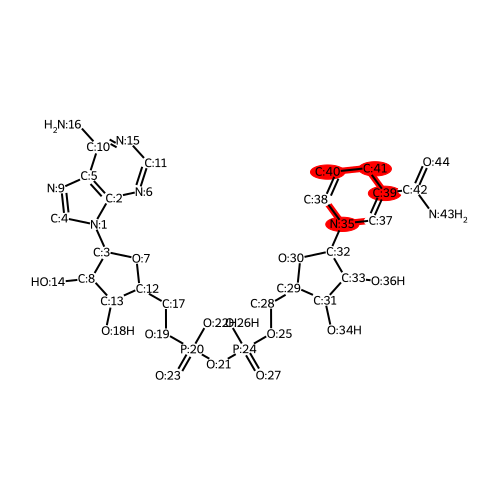

In [12]:
img = rxn.get_images()[0]
display(img)

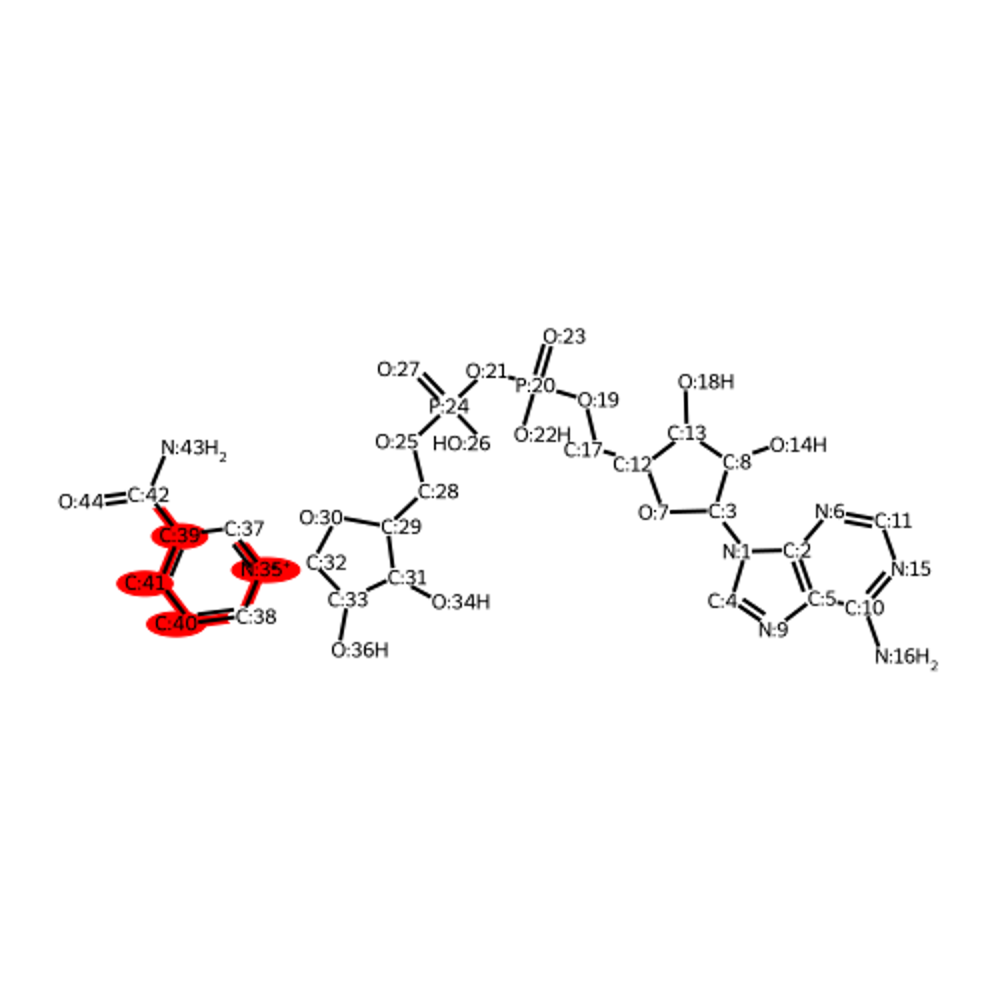

In [13]:
img = rxn.get_images()[1]
img = img.resize((img.width * 2, img.height * 2))
display(img)

In [14]:
rxn.reactants[0].graph

{Atom(1, N, N4y, 0): [Bond(Atom(2, C, C8y, 0), AROMATIC),
  Bond(Atom(3, C, C1y, 0), 1),
  Bond(Atom(4, C, C8x, 0), AROMATIC)],
 Atom(2, C, C8y, 0): [Bond(Atom(1, N, N4y, 0), AROMATIC),
  Bond(Atom(5, C, C8y, 0), AROMATIC),
  Bond(Atom(6, N, N5x, 0), AROMATIC)],
 Atom(3, C, C1y, 0): [Bond(Atom(1, N, N4y, 0), 1),
  Bond(Atom(7, O, O2x, 0), 1),
  Bond(Atom(8, C, C1y, 0), 1)],
 Atom(4, C, C8x, 0): [Bond(Atom(1, N, N4y, 0), AROMATIC),
  Bond(Atom(9, N, N5x, 0), AROMATIC)],
 Atom(5, C, C8y, 0): [Bond(Atom(2, C, C8y, 0), AROMATIC),
  Bond(Atom(9, N, N5x, 0), AROMATIC),
  Bond(Atom(10, C, C8y, 0), AROMATIC)],
 Atom(6, N, N5x, 0): [Bond(Atom(2, C, C8y, 0), AROMATIC),
  Bond(Atom(11, C, C8x, 0), AROMATIC)],
 Atom(7, O, O2x, 0): [Bond(Atom(3, C, C1y, 0), 1),
  Bond(Atom(12, C, C1y, 0), 1)],
 Atom(8, C, C1y, 0): [Bond(Atom(3, C, C1y, 0), 1),
  Bond(Atom(13, C, C1y, 0), 1),
  Bond(Atom(14, O, O1a, 0), 1)],
 Atom(9, N, N5x, 0): [Bond(Atom(4, C, C8x, 0), AROMATIC),
  Bond(Atom(5, C, C8y, 0), AROMATI

In [15]:
rxn.products[0].graph

{Atom(33, C, C1y, 0): [Bond(Atom(31, C, C1y, 0), 1),
  Bond(Atom(32, C, C1y, 0), 1),
  Bond(Atom(36, O, O1a, 0), 1)],
 Atom(31, C, C1y, 0): [Bond(Atom(29, C, C1y, 0), 1),
  Bond(Atom(33, C, C1y, 0), 1),
  Bond(Atom(34, O, O1a, 0), 1)],
 Atom(29, C, C1y, 0): [Bond(Atom(28, C, C1b, 0), 1),
  Bond(Atom(30, O, O2x, 0), 1),
  Bond(Atom(31, C, C1y, 0), 1)],
 Atom(30, O, O2x, 0): [Bond(Atom(29, C, C1y, 0), 1),
  Bond(Atom(32, C, C1y, 0), 1)],
 Atom(32, C, C1y, 0): [Bond(Atom(30, O, O2x, 0), 1),
  Bond(Atom(33, C, C1y, 0), 1),
  Bond(Atom(35, N, N5y, 1), 1)],
 Atom(36, O, O1a, 0): [Bond(Atom(33, C, C1y, 0), 1)],
 Atom(34, O, O1a, 0): [Bond(Atom(31, C, C1y, 0), 1)],
 Atom(28, C, C1b, 0): [Bond(Atom(25, O, O2b, 0), 1),
  Bond(Atom(29, C, C1y, 0), 1)],
 Atom(35, N, N5y, 1): [Bond(Atom(32, C, C1y, 0), 1),
  Bond(Atom(37, C, C8x, 0), AROMATIC),
  Bond(Atom(38, C, C8x, 0), AROMATIC)],
 Atom(25, O, O2b, 0): [Bond(Atom(24, P, P1b, 0), 1),
  Bond(Atom(28, C, C1b, 0), 1)],
 Atom(24, P, P1b, 0): [Bond(At